# Preprocessing af SDU dataset

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays

## Dumb Charging Data

In [62]:
# Input from csv "Jan 1, 2020, 12:00:07 AM"
def parse_date(date):
    return pd.to_datetime(date, format='%b %d, %Y, %I:%M:%S %p')

def add_features(hourly_df):
  ####################### TIMED BASED FEATURES  #######################
  hourly_df['Day_of_Week'] = hourly_df.index.dayofweek

  # Add hour of the day
  hourly_df['Hour_of_Day'] = hourly_df.index.hour

  # Add month of the year
  hourly_df['Month_of_Year'] = hourly_df.index.month

  # Add year
  hourly_df['Year'] = hourly_df.index.year

  # Add day/night
  hourly_df['Day/Night'] = (hourly_df['Hour_of_Day']>= 6) & (hourly_df['Hour_of_Day'] <= 18)

  # Add holiday
  dk_holidays = holidays.DK(years=range(2020, 2032 + 1))
  hourly_df['IsHoliday'] = hourly_df.index.map(lambda x: 1 if x.date() in dk_holidays else 0)

  # Add weekend
  hourly_df['Weekend'] = (hourly_df['Day_of_Week'] >= 5).astype(int)

  ####################### CYCLIC FEATURES  #######################
  # Cos and sin transformations for cyclic features (hour of the day, day of the week, month of the year)

  hourly_df['HourSin'] = np.sin(2 * np.pi * hourly_df['Hour_of_Day'] / 24)
  hourly_df['HourCos'] = np.cos(2 * np.pi * hourly_df['Hour_of_Day'] / 24)
  hourly_df['DayOfWeekSin'] = np.sin(2 * np.pi * hourly_df['Day_of_Week'] / 7)
  hourly_df['DayOfWeekCos'] = np.cos(2 * np.pi * hourly_df['Day_of_Week'] / 7)
  hourly_df['MonthOfYearSin'] = np.sin(2 * np.pi * hourly_df['Month_of_Year'] / 12)
  hourly_df['MonthOfYearCos'] = np.cos(2 * np.pi * hourly_df['Month_of_Year'] / 12)

  ####################### SEASONAL FEATURES  #######################
  month_to_season = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer',
                     7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'}
  hourly_df['Season'] = hourly_df['Month_of_Year'].map(month_to_season)

  ####################### HISTORICAL CONSUMPTION FEATURES  #######################
  # Lag features
  # 1h
  hourly_df['Aggregated_charging_load_1h'] = hourly_df['Aggregated charging load'].shift(1)

  # 6h
  hourly_df['Aggregated_charging_load_6h'] = hourly_df['Aggregated charging load'].shift(6)

  # 12h
  hourly_df['Aggregated_charging_load_12h'] = hourly_df['Aggregated charging load'].shift(12)

  # 24h
  hourly_df['Aggregated_charging_load_24h'] = hourly_df['Aggregated charging load'].shift(24)

  # 1 week
  hourly_df['Aggregated_charging_load_1w'] = hourly_df['Aggregated charging load'].shift(24*7)

  # Rolling average
  # 24h
  hourly_df['Aggregated_charging_load_rolling'] = hourly_df['Aggregated charging load'].rolling(window=24).mean()

  return hourly_df

def filter_data(start_date, end_date, data):
    ####################### FILTER DATASET  #######################
    data = data[(data.index >= start_date) & (data.index <= end_date)].copy()

    return data


# Define the start and end dates
start_date = pd.to_datetime('2022-11-30')
end_date = pd.to_datetime('2023-11-30')

df_dumb = pd.read_csv('./DumbCharging_2020_to_2032/Measurements.csv')

df_dumb['Timestamp'] = df_dumb['Timestamp'].apply(parse_date)
df_dumb = df_dumb.set_index('Timestamp')

# Resample to hourly data but still contain the same data contain multiple decimal number
df_dumb = df_dumb.resample('h').mean()

# Drop NaN
df_dumb = df_dumb.dropna()

# Drop rows 
df_dumb = df_dumb.drop(columns=['Passed hours', 'Year', 'Month', 'Day', 'Hour', 'Minute'])

# Add features
df_dumb = add_features(df_dumb)

# Filter data
#df_dumb = filter_data(start_date, end_date, df_dumb)

print(df_dumb.head(24))

                     Total number of EVs  Number of charging EVs  \
Timestamp                                                          
2020-01-01 00:00:00                  1.0                     0.0   
2020-01-01 01:00:00                  1.0                     0.0   
2020-01-01 02:00:00                  1.0                     0.0   
2020-01-01 03:00:00                  1.0                     0.0   
2020-01-01 04:00:00                  1.0                     0.0   
2020-01-01 05:00:00                  1.0                     0.0   
2020-01-01 06:00:00                  1.0                     0.0   
2020-01-01 07:00:00                  1.0                     0.0   
2020-01-01 08:00:00                  1.0                     0.0   
2020-01-01 09:00:00                  1.0                     0.0   
2020-01-01 10:00:00                  1.0                     0.0   
2020-01-01 11:00:00                  1.0                     0.0   
2020-01-01 12:00:00                  1.0        

## Plotting dataset

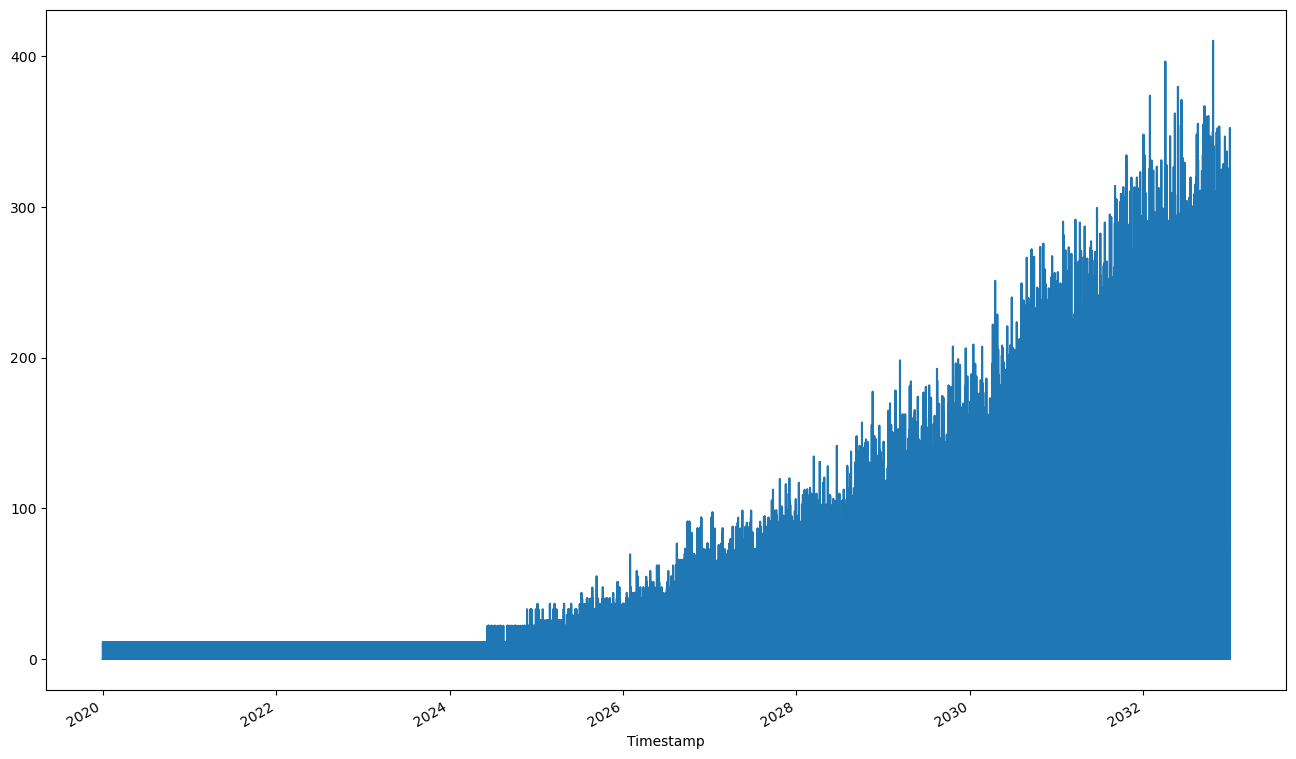

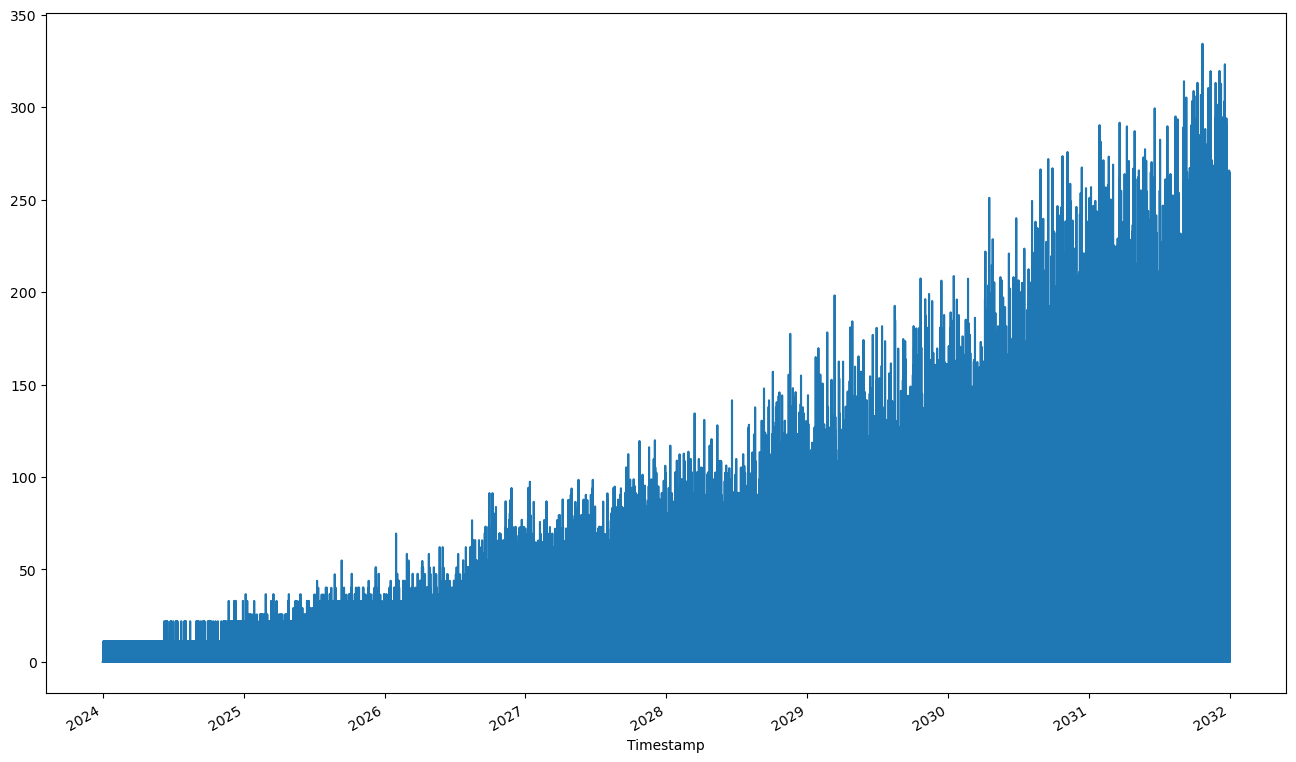

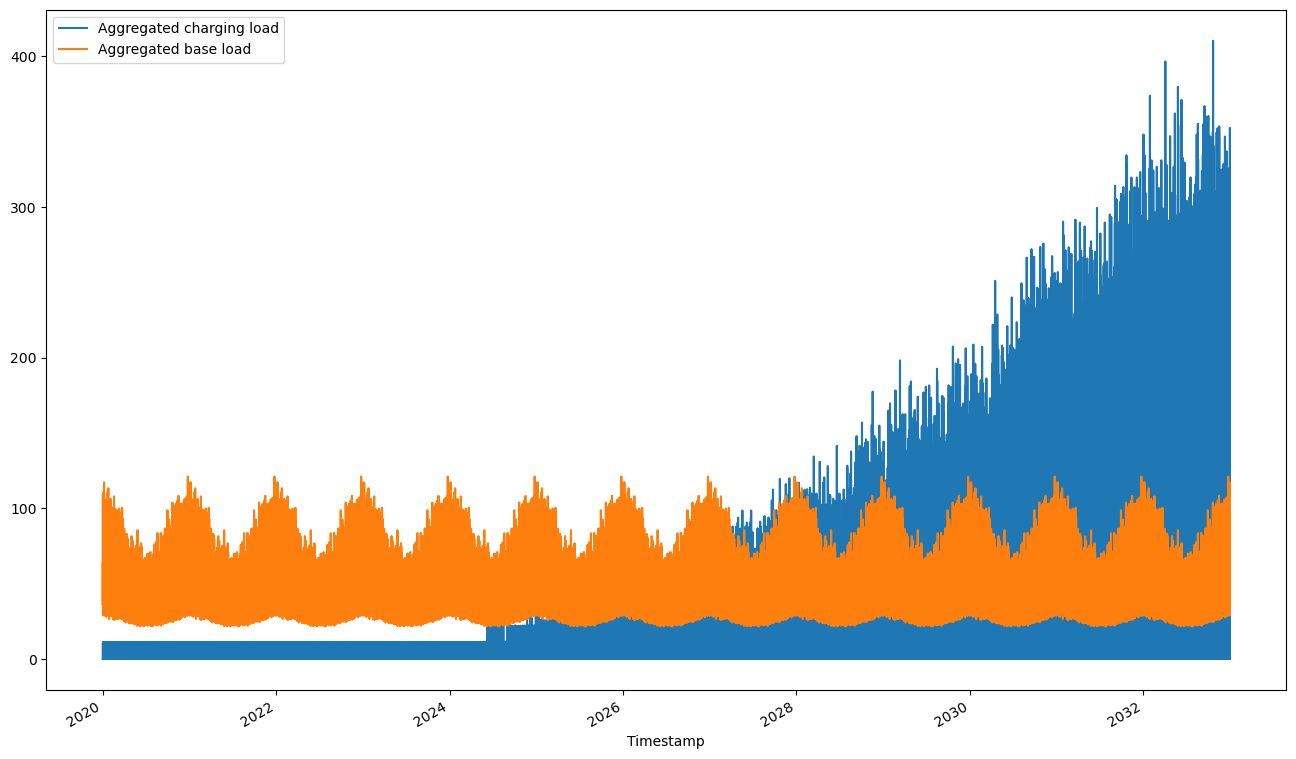

In [61]:
# plot the average charging load over the years 
df_dumb['Aggregated charging load'].plot(figsize=(16, 10))
plt.show()

#plot 2024 - 2032
df_dumb['Aggregated charging load'].loc['2024-01-01':'2032-01-01'].plot(figsize=(16, 10))
plt.show()

# plot Agrergated charging load with Aggregated base load
df_dumb[['Aggregated charging load', 'Aggregated base load']].plot(figsize=(16, 10))
plt.show()
